# Pipeline Example

本章節將會以動能交易策略示範 Pipeline 於交易策略中使用方法，並且會介紹 before_trading_start 與 schedule_function 兩函式。

交易策略: 
1. 每月月底買入 RSI 前 5 名至投組總額 20%。
2. 每月月底賣出非 RSI 前 5 名。

## 股票下載

In [118]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 

os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = "your key"
os.environ['mdate'] = "20120101 20231231"
os.environ['ticker'] = "2330 2337 2454 2201 2498 2317 2881 2882 1101 2408 2388 2449 2603 2617 IR0001"

!zipline ingest -b tquant

Merging daily equity files:


[2023-08-08 08:24:58.528465] INFO: zipline.data.bundles.core: Ingesting tquant.


## 導入套件

In [119]:
from zipline import run_algorithm
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import RSI
from zipline.pipeline.filters import SingleAsset, StaticSids
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    symbol,
    schedule_function,
    set_benchmark
)

## 建立 Pipeline 函式

使用 Pipeline 計算每檔標的於每日的 RSI 值，zipline 有內建的 RSI factor。

### zipline.pipeline.factors.RSI

計算 RSI 指標。公式為:

$$ 
RSI=100 \times \frac{n日漲幅平均值}{(n日漲幅平均值+n日跌幅平均值)} 
$$ 

#### Parameters:

* inputs: _zipline.pipeline.data.Dataset._
        價格資料，預設 = zipline.pipeline.data.EquityPricing.close (收盤價)。
* window_length: _int_
        計算 RSI 的窗格，也就是上述數學式的 n，預設 = 15。
* mask: _zipline.pipeline.Filter_
        設置過濾特定資產的條件。

其中我們使用 `top` 函式取用每次交易日 RSI 值前 5 名的資產。並且設置:
```
mask = ~SingleAsset(symbol("IR0001"))
```
以避免計算市場大盤指標的 RSI 值。

In [120]:
def make_pipeline():
    rsi = RSI()
    return Pipeline(
        columns = {
            "longs" : rsi.top(5, mask = ~SingleAsset(symbol("IR0001")))
        }
    )

## 建立 before_trading_start 函式

before_trading_start 函式會在每次交易日前呼叫一次，與 initialize 不同，initialize 是在回測前呼叫，因此一些會隨著交易日而變動的設定或資料可以在 before_trading_start 中處理。在這次舉例中，我們在 before_trading_start 引入每日 Pipeline 運算結果，並且記錄在 context 中。


In [ ]:
def before_trading_start(context, data):
    context.pipeline_data = pipeline_output('my_pipeline')

## 建立 handle_data 函式

handle_data 主要交易策略與下單執行，詳細介紹請見過去課程。

In [ ]:
def handle_data(context, data):
    pipeline_data = context.pipeline_data # 自 context 引入 pipeline 運算結果
    all_assets = pipeline_data.index 
    
    record(
        stocks_number = len(all_assets) # 於最終輸出的 results 表格紀錄所有股票的數量
    )
    
    perc = 1 / 5
    
    # 若為 RSI 值當日前 5 名，則持有至所有資產總額的 1/5
    longs = all_assets[pipeline_data.longs] 
    for asset in longs:
        order_target_percent(asset, perc)
    
    
    positions = context.portfolio.positions.keys() # 當日前持有部位的股票標的
    # 挑出並非當日前 5 名且日前持有的標的，並且將其部位清空
    for asset in positions - longs:
        if data.can_trade(asset): 
            order_target_percent(asset, 0)

## 建立 initialize 函式

我們設置:

* attach_pipeline(make_pipeline(), 'my_pipeline'): 將 Pipeline 運算導入回測中。
* schedule_function(handle_data, date_rules.month_end()): 設定每次月底才執行 handle_data。
* set_benchmark(symbol('IR0001')): 將市場大盤指數設定為比較績效之基準。

其中:

### zipline.api.attach_pipeline

於每次交易日前執行一次 pipeline。

#### Parameters:
* pipeline: _zipline.pipeline.Pipeline_
        欲計算的 pipeline。
* name: _str_
        給予上述之 pipeline 名稱。
* chunks: _int_ or _iterator_, optional
        The number of days to compute pipeline results for.
* eager : _boolean_, optional
        是否在 before_trading_start 前執行 pipeline。

#### Returns

    pipeline 

### zipline.api.schedule_function

將函式進行排程，以便於日後可以重複執行，可以更改執行頻率。

#### Parameters:
* func: _callable_
        用於排程的函示。
* date_rule: _zipline.utils.events.EventRule_, optional
        決定何日執行函式，預設為每日。
* time_rule: _zipline.utils.events.EventRule_, optional
        決定一日中何時點執行程式，預設為每日第一分鐘。
* half_days: _boolean_, optional
        是否在每日日中結束執行程式，預設 = False。
* calendar : _Sentinel_, optional
        交易日曆。

In [ ]:
def initialize(context):
    attach_pipeline(make_pipeline(), 'my_pipeline')
    schedule_function(handle_data, date_rules.month_end()) # 每月月底執行 handle_data
    set_benchmark(symbol('IR0001'))

## 建立 analyze 函式

繪製策略與基準的累積報酬圖與交易次數圖，其中 analyze(context, perf) 中的 perf 就是最終 results 表格。

In [148]:
def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.algorithm_period_return.plot(ax=ax1)
    perf.benchmark_period_return.plot(ax=ax1)
    plt.title("Return Comparison")
    plt.legend()
    
    ax2 = plt.subplot(212, sharex=ax1)
    num_trans = [len(i) for i in results.transactions]
    plt.plot(perf.index, num_trans)
    plt.legend()
    plt.title("Numbers of transactions")
    
    plt.gcf().set_size_inches(18, 14)
    plt.show()

## 執行策略

請注意我們並未設置 handle_data 參數，而是在 schedule_function 時就設定好策略與下單方法。 從圖二可以發現，確實我們每次交易都在月底。

C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


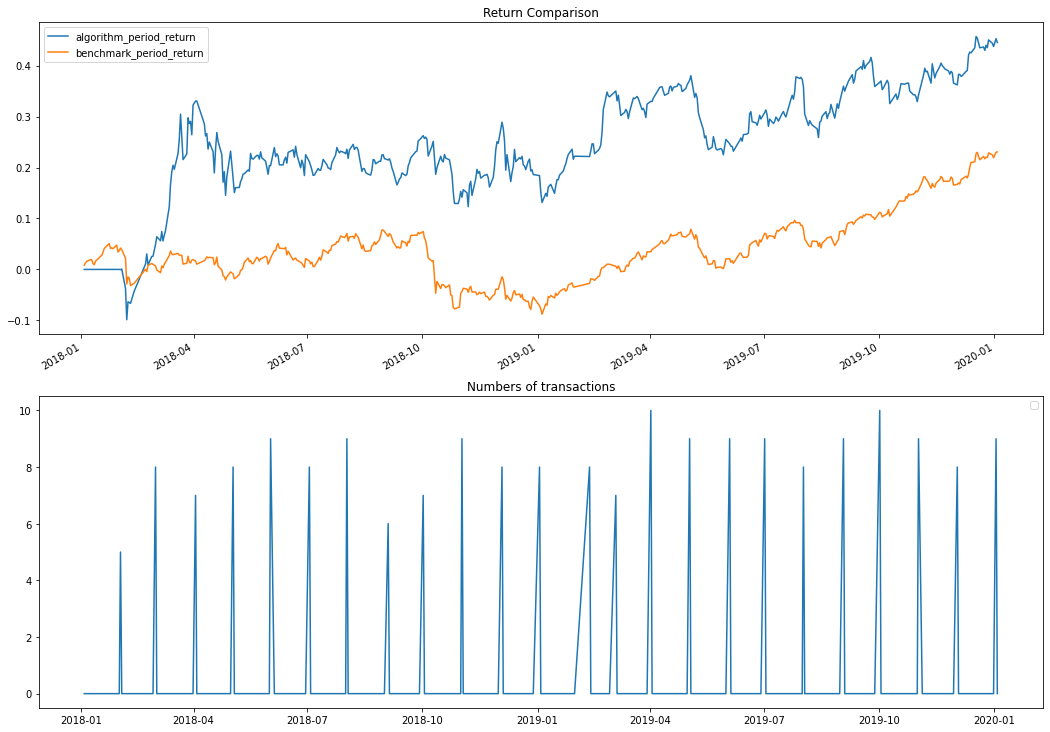

,period_open,period_close,starting_cash,ending_cash,returns,portfolio_value,longs_count,shorts_count,long_value,short_value,...,benchmark_volatility,treasury_period_return,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,trading_days,stocks_number
2018-01-03 13:30:00+08:00,2018-01-03 09:01:00+08:00,2018-01-03 13:30:00+08:00,100000.000000,100000.000000,0.000000,100000.000000,0,0,0.00,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,1,NaN
2018-01-04 13:30:00+08:00,2018-01-04 09:01:00+08:00,2018-01-04 13:30:00+08:00,100000.000000,100000.000000,0.000000,100000.000000,0,0,0.00,0.0,...,0.046297,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,2,NaN
2018-01-05 13:30:00+08:00,2018-01-05 09:01:00+08:00,2018-01-05 13:30:00+08:00,100000.000000,100000.000000,0.000000,100000.000000,0,0,0.00,0.0,...,0.046130,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,3,NaN
2018-01-08 13:30:00+08:00,2018-01-08 09:01:00+08:00,2018-01-08 13:30:00+08:00,100000.000000,100000.000000,0.000000,100000.000000,0,0,0.00,0.0,...,0.040668,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,4,NaN
2018-01-09 13:30:00+08:00,2018-01-09 09:01:00+08:00,2018-01-09 13:30:00+08:00,100000.000000,100000.000000,0.000000,100000.000000,0,0,0.00,0.0,...,0.049167,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27 13:30:00+08:00,2019-12-27 09:01:00+08:00,2019-12-27 13:30:00+08:00,-653.702694,-653.702694,0.010657,145044.547306,5,0,145698.25,0.0,...,0.133865,0.0,0.095492,1.109851,0.946870,1.381139,-0.155946,1.040211,486,15.0
2019-12-30 13:30:00+08:00,2019-12-30 09:01:00+08:00,2019-12-30 13:30:00+08:00,-653.702694,-653.702694,-0.004574,144381.047306,5,0,145034.75,0.0,...,0.133752,0.0,0.094665,1.110000,0.935558,1.364539,-0.155946,1.040211,487,15.0
2019-12-31 13:30:00+08:00,2019-12-31 09:01:00+08:00,2019-12-31 13:30:00+08:00,-653.702694,-653.702694,-0.004428,143741.797306,5,0,144395.50,0.0,...,0.133666,0.0,0.094893,1.109942,0.924609,1.348478,-0.155946,1.040211,488,15.0
2020-01-02 13:30:00+08:00,2020-01-02 09:01:00+08:00,2020-01-02 13:30:00+08:00,-653.702694,95.113981,0.010750,145287.063981,5,0,145191.95,0.0,...,0.133657,0.0,0.095337,1.110138,0.947151,1.382001,-0.155946,1.040211,489,15.0


In [149]:
results = run_algorithm(
    start = pd.Timestamp('2018-01-03', tz='UTC'),
    end = pd.Timestamp('2020-01-03', tz ='UTC'),
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e5,
    before_trading_start=before_trading_start
)

results